# Load modules

In [2]:
# This modles that we will use for this notebook.
import json

import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms
torch.manual_seed(0)

## Utility functions

In [3]:
def save_data(name, start_data, target_data):
    """ Save data to parquet files and update info.json.  

    The start_data is the start of a trajectory and the target_data is the end of the trajectory.  
    Classically the target_data lay on the manifold of interest and is the "clean" data.
    Simlarly the start_data is the "noisy" data, for example an MNIST image with the classification label ramdomly chosen.

    Args: name (str): Name of the dataset.
            start_data (list): List of start data.
            target_data (list): List of target data.    

    Returns: None
    """
    target_df = pd.DataFrame(target_data)
    start_df = pd.DataFrame(start_data)

    data_info = {
        'num_points': start_df.shape[0]
    }

    with open(f'{data_dir}/info.json', 'r') as f:
        info = json.load(f)

    if name in info:
        info[name].update(data_info)
    else:
        info[name] = data_info

    with open(f'{data_dir}/info.json', 'w') as f:
        json.dump(info, f)

    start_df.to_parquet(f'{data_dir}/{name}_start.parquet')
    target_df.to_parquet(f'{data_dir}/{name}_target.parquet')

# The Data



We want a simple yet non-trivial problem for demonstrating the methods, so we do a manifold problem.  I.e., there is a space that contains a manifold of some given form and dimension, and each training example is a point on the manifold.  The idea is to train the model to be a dynamical system where the manifold is an attractor.

For example, we can use a simple manifold, such as a circle in 2D.  We can use a circle because it is easy to visualize and easy to generate.  
However, other manifolds are also possible.

Another example would be a 2D Swiss roll, which is a classic 2D manifold in 3D space.  This is a bit more complicated to generate, but it is still easy to visualize.

A final example could be MNIST, where the manifold is the set of all possible images of a given digit.  This is a much more complicated manifold.  Note, we can, and should, condition the problem where each image is labeled with its true digit.

Note, we will proceed in two steps.  First we will generat the appropriate training data as a Pandas frame, then we will read in the data to train the model.  This notebook focuses on the first step.

In [4]:
data_dir = '../data/processed'

In [5]:
# Create an empty json file at ../data/processed/info.json
info = {}
with open(f'{data_dir}/info.json', 'w+') as f:
    json.dump(info, f)

The data consists of pairs of vectors, where the first vector is a starting vector and the second vector is the target vector.  The input vector is a point not on the manifold, and the target vector some point on the manifold we want the input vector to converge to.  The idea is to train the model to be a dynamical system where the manifold is an attractor where the starting vector is attracted to the target vector.

# Regression line

In [6]:
num_points = 1000
name='regression_line'
# The poits on the line
x_on = np.random.uniform(0, 1, num_points)
y_on = 0.73*x_on
# The points off the line
x_off = x_on
y_off = y_on + np.random.normal(0, 0.1, num_points)

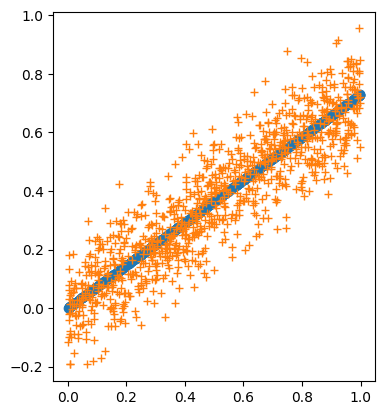

In [7]:
_, ax = plt.subplots()
ax.plot(x_on, y_on, 'o')
ax.plot(x_off, y_off, '+')
ax.set_aspect('equal')

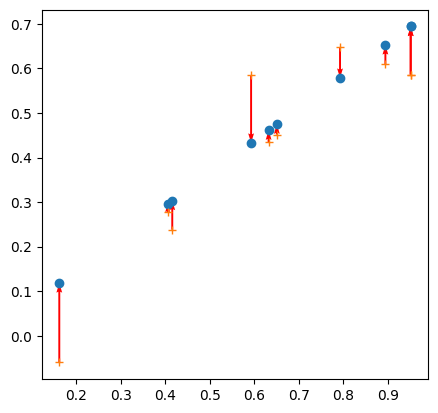

In [8]:

idx = np.random.choice(range(num_points), 10)
_, ax = plt.subplots()
ax.plot(x_on[idx], y_on[idx], 'o')
ax.plot(x_off[idx], y_off[idx], '+')
ax.quiver(x_off[idx], y_off[idx], x_on[idx]-x_off[idx], y_on[idx]-y_off[idx],
          scale=1, scale_units='xy', angles='xy', color='r', width=0.005)
ax.set_aspect('equal')

In [9]:
start_data = {f'x{i}': columns for i, columns in enumerate([x_off, y_off])}
target_data = {f'x{i}': columns for i, columns in enumerate([x_on, y_on])}
save_data(name, start_data, target_data)

# PCA line

In [10]:
num_points = 1000
name='pca_line'
# The poits on the line
rho = np.random.uniform(0, 1, num_points)
theta = 0.54
x_on = rho*np.cos(theta)
y_on = rho*np.sin(theta)
# The points off the line
gamma = np.random.normal(0, 0.1, num_points)
x_off = x_on + gamma*np.cos(theta+np.pi/2.0)
y_off = y_on + gamma*np.sin(theta+np.pi/2.0)

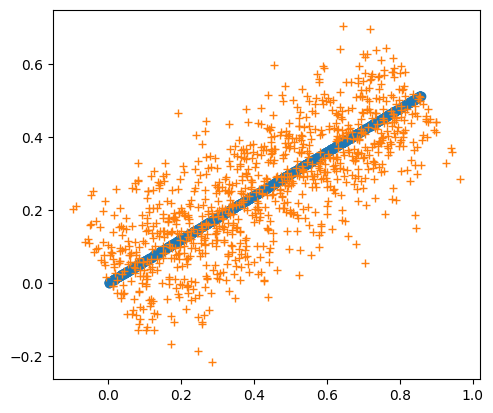

In [11]:
_, ax = plt.subplots()
ax.plot(x_on, y_on, 'o')
ax.plot(x_off, y_off, '+')
ax.set_aspect('equal')

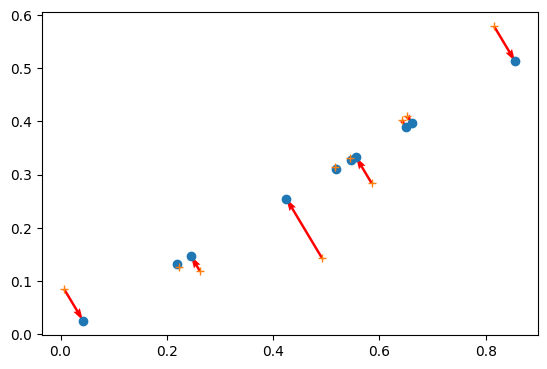

In [12]:

idx = np.random.choice(range(num_points), 10)
_, ax = plt.subplots()
ax.plot(x_on[idx], y_on[idx], 'o')
ax.plot(x_off[idx], y_off[idx], '+')
ax.quiver(x_off[idx], y_off[idx], x_on[idx]-x_off[idx], y_on[idx]-y_off[idx],
          scale=1, scale_units='xy', angles='xy', color='r', width=0.005)
ax.set_aspect('equal')

In [13]:
start_data = {f'x{i}': columns for i, columns in enumerate([x_off, y_off])}
target_data = {f'x{i}': columns for i, columns in enumerate([x_on, y_on])}
save_data(name, start_data, target_data)

# Circle

In [14]:
num_points = 1000
name='circle'
thetas = np.random.uniform(0, 2*np.pi, num_points)
# The poits on the unit circle
x_on = np.cos(thetas)
y_on = np.sin(thetas)
# The points off the unit circle
r_off = np.random.uniform(0.8, 1.2, num_points)
x_off = r_off*np.cos(thetas)
y_off = r_off*np.sin(thetas)

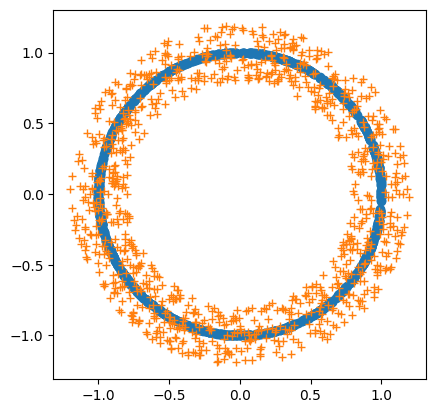

In [15]:
_, ax = plt.subplots()
ax.plot(x_on, y_on, 'o')
ax.plot(x_off, y_off, '+')
ax.set_aspect('equal')

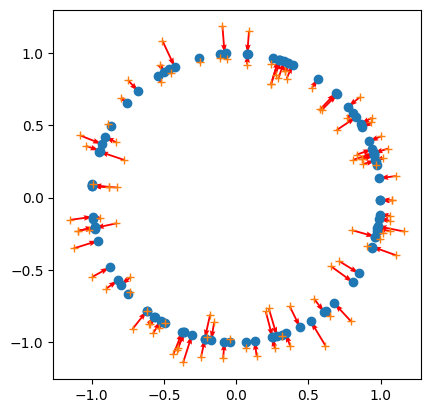

In [16]:
idx = np.random.choice(range(num_points), 100)
_, ax = plt.subplots()
ax.plot(x_on[idx], y_on[idx], 'o')
ax.plot(x_off[idx], y_off[idx], '+')
ax.quiver(x_off[idx], y_off[idx], x_on[idx]-x_off[idx], y_on[idx]-y_off[idx],
          scale=1, scale_units='xy', angles='xy', color='r', width=0.005)
ax.set_aspect('equal')

In [17]:
start_data = {f'x{i}': columns for i, columns in enumerate([x_off, y_off])}
target_data = {f'x{i}': columns for i, columns in enumerate([x_on, y_on])}
save_data(name, start_data, target_data)

# Regression circle

In [18]:
num_points = 1000
name='regression_circle'
thetas = np.random.uniform(0, 2*np.pi, num_points)
# The poits on the unit circle
x_on = np.cos(thetas)
y_on = np.sin(thetas)
# The points off the unit circle
y_noise = np.random.normal(0, 0.2, num_points)
x_off = np.cos(thetas)
y_off = np.sin(thetas)+y_noise

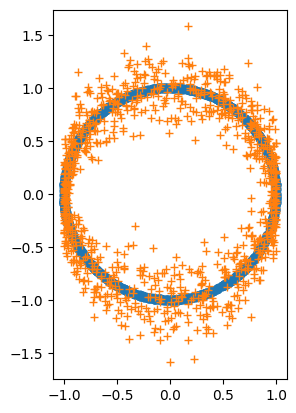

In [19]:
_, ax = plt.subplots()
ax.plot(x_on, y_on, 'o')
ax.plot(x_off, y_off, '+')
ax.set_aspect('equal')

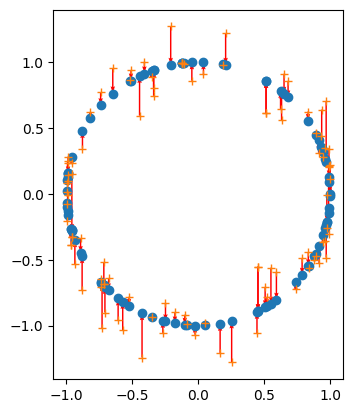

In [20]:
idx = np.random.choice(range(num_points), 100)
_, ax = plt.subplots()
ax.plot(x_on[idx], y_on[idx], 'o')
ax.plot(x_off[idx], y_off[idx], '+')
ax.quiver(x_off[idx], y_off[idx], x_on[idx]-x_off[idx], y_on[idx]-y_off[idx],
          scale=1, scale_units='xy', angles='xy', color='r', width=0.005)
ax.set_aspect('equal')

In [21]:
start_data = {f'x{i}': columns for i, columns in enumerate([x_off, y_off])}
target_data = {f'x{i}': columns for i, columns in enumerate([x_on, y_on])}
save_data(name, start_data, target_data)

# Manifold

In [22]:
num_points = 1000
name='manifold'

# Define the function that generates the Swiss roll points
def swiss_roll(n_samples=1000):
    # Generate random values for u and v
    u = np.random.rand(n_samples) 
    v = np.random.rand(n_samples)

    # Define the function that maps u and v to x, y, and z coordinates
    x = np.cos(u * 2 * np.pi) * (1-0.5*u)
    y = np.sin(u * 2 * np.pi) * (1-0.5*u)
    z = v

    # Return the points as a numpy array
    return np.column_stack((x, y, z))

x_on = swiss_roll(num_points)

# The points off the manifold
x_off = x_on + np.random.normal(0, 0.1, (num_points, 3))

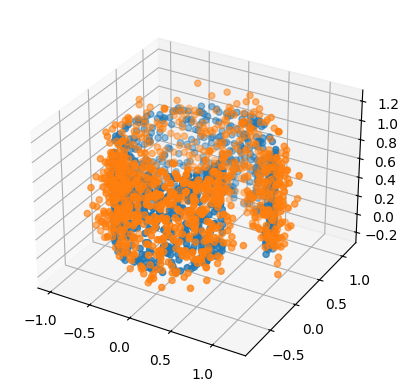

In [23]:
# a plot of the manifold
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_on[:, 0], x_on[:, 1], x_on[:, 2], 'o')
ax.scatter(x_off[:, 0], x_off[:, 1], x_off[:, 2], '+')

In [24]:
start_data = {f'x{i}': x_off[:,i] for i in range(x_off.shape[1])}
target_data = {f'x{i}': x_on[:,i] for i in range(x_on.shape[1])}
save_data(name, start_data, target_data)

 # MNIST



In [25]:
name='MNIST'

# get a list of pytorch vectors, one for each MNIST digit, with the last entry being the classification

# Define the transformation to apply to the MNIST images
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
mnist_dataset = datasets.MNIST(root='../data/external/', train=True, download=True, transform=transform)

# Define the number of digits and the dimensionality of each vector
num_digits = 10000
vector_dim = 28 * 28

# Create a list of PyTorch tensors containing the MNIST digits
digit_tensors = []
for i in range(num_digits):
    random_image, label = mnist_dataset[np.random.randint(len(mnist_dataset))]

    # Flatten the image into a PyTorch tensor
    digit_tensor = random_image.view(-1)

    # Append the classification label to the end of the tensor
    digit_tensor = torch.cat((digit_tensor, torch.tensor([label])))

    # Append the tensor to the list of digit tensors
    digit_tensors.append(digit_tensor)

# x_on contains the MNIST digits with the correct classification
x_on = torch.stack(digit_tensors)
# x_ff contains the MNIST digits with a random classification
x_off = torch.stack(digit_tensors)
x_off[:, -1] = torch.randint(10, size=(num_digits,))

23.8%

100.0%


Extracting ../data/external/MNIST/raw/train-images-idx3-ubyte.gz to ../data/external/MNIST/raw


100.0%
100.0%


Extracting ../data/external/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/external/MNIST/raw

Extracting ../data/external/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/external/MNIST/raw



100.0%



Extracting ../data/external/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/external/MNIST/raw



The start classification label is 4.0
The target classification label is 7.0


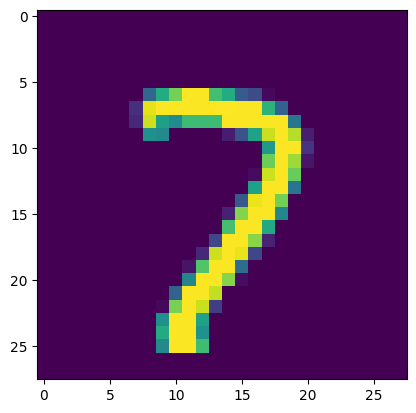

In [26]:
plot_index = 0
fig, ax = plt.subplots()
ax.imshow(x_on[plot_index, :-1].view(28, 28).numpy())
print(f'The start classification label is {x_off[plot_index,-1]}')
print(f'The target classification label is {x_on[plot_index,-1]}')


In [27]:
start_data = {f'x{i}': x_off[:,i] for i in range(x_off.shape[1])}
target_data = {f'x{i}': x_on[:,i] for i in range(x_on.shape[1])}
save_data(name, start_data, target_data)

# Electric Field Range Localization


In [28]:
name = 'EMlocalization'
X = torch.load('../data/raw/EM_X_train.pt')
Y = torch.load('../data/raw/EM_Y_train.pt')

x_on = torch.cat((X, Y), dim=1)

In [29]:
# Now set the last entry of x_off to be a random range in the same range as the target
x_off = x_on.clone()
#x_off[:, -1].uniform_(float(x_on[:,-1].min()), float(x_on[:,-1].max()))
x_off[:, -1] += torch.randn(x_off[:, -1].shape)*5000.0
print(x_on[:3, -1])
print(x_off[:3, -1])


tensor([16740.1992, 47319.7305, 25766.9609])
tensor([ 6801.8779, 50626.0195, 24577.2930])


In [30]:
start_data = {f'x{i}': x_off[:,i] for i in range(x_off.shape[1])}
target_data = {f'x{i}': x_on[:,i] for i in range(x_on.shape[1])}
save_data(name, start_data, target_data)